# Assignment 3

**Deadline**:  15/10/2024, 17:00

**Names and student numbers:**
1. Paolo Cadei

**Exercise:** import the relevant libraries.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Instructions
In this assignment you have to develop a regression model. You will be given a training set of 800 datapoints. Using the techniques presented in this course, we ask you to come up with a model that has the best generalization performance. This performance will be assessed on a test dataset of 16,000 datapoints, which is not available to you. The assignment is also a competition: your mark depends (partly) on how well your model does compared to those of other groups and the three groups with the best performing model will be announced on Canvas.

### The data
The training data can be found in the file “training_data.csv” on Canvas. It consists of a two-dimensional comma-separated matrix of 800 rows and 27 columns. Each row is a datapoint, consisting of 26 input variables and 1 target variable. The target variable is the last column of the matrix.

### Submitting your work
Your work in this Jupyter notebook consists of two parts. **Part 1** is used to train, create and evaluate your best performing model. In the first cell, you have to train your best performing model on the training data. The code to load the training data is already given. Furthermore, in that same cell you have to create a function called `best_model`. This function has a single input argument, which is a 2-dimensional NumPy array with an arbitrary number of rows and 26 columns (e.g. the input features `X` of the training data). The function should return a 1-dimensional array with the predictions of your best model for the datapoints in the input argument. Hence, the number of elements in this 1-dimensional array should be equal to the number of rows of the 2-dimensional array used as input argument.

In the second cell, we are using a testset called `test_data.csv` of 16,000 datapoints to assess the generalization performance of your function `best_model`. Of course, the testset is only available to the teachers. The code in the second cell may not be changed!!! It will be used by the teachers to compute the generalization performance of your best model. On Canvas, you can find a file called `FAKE_test_data.csv`. This is a 2-dimensional array of completely random numbers (fake data), having the same dimensions as the dataset in `test_data.csv`. If you put this file in the same folder as this Jupyter notebook, you can test whether your function `best_model` is defined correctly by checking if the second cell runs without errors. Since the numbers in `FAKE_test_data.csv` are fake data, they **cannot** be used to estimate the performance of your `best_model`. **AFTER TRAINING AND CREATING YOUR BEST MODEL IN THE FIRST CELL, THE SECOND CELL SHOULD RUN WITHOUT ERRORS!!!** If this is not the case, your work will **not** be marked. 

In **Part 2** of the notebook, you will present your analysis of the regression problem and the steps you have taken to arrive at your best model. Here, you have to explain and perform all the methods that you have used to identify your best model. As in all exercises, please make sure all steps are well motivated and presented in a clear and structured manner. We recommend using visualization methods (e.g., plots with matplotlib), if applicable, to clarify your work.

### Examples
On Canvas, you can find two example notebooks (“DSM_assignment3_example_with_sklearn.ipynb”, “DSM_assignment3_example_without_sklearn.ipynb”). These notebooks contain examples of how you can submit **Part 1** of the assignment. As "best model" in the examples, we have **arbitrarily** chosen for a regression model using the third power of the 7-th principal component. In one of the files we use scikit-learn, whereas in the other one we train the same model without using scikit-learn. Please look carefully at how the function `best_model` is created and make sure you understand all steps.

### Allowed methods
Any of the methods discussed in the course may be used. You are also allowed to combine different models and techniques. If you doubt whether your method is allowed, please consult with the teachers. 

Furthermore, you are allowed to use libraries like scikit-learn, but you are not required to use them.

### The competition
The generalization performance of your best model is assessed by the **root mean squared error (RMSE)** on a secret test dataset consisting of 16,000 independent and identically distributed datapoints. They were created with the same data-generating process as the data of the training set of 800 datapoints. The scores will be ranked and the top-three groups and their scores will be announced in class.

### The marking
As can be seen in the rubric on Canvas, 20% of your mark will depend on the generalization performance of your best model, compared to the best models of your peers. The other 80% is for the quality of your analysis and your code.

# Part 1: training, creating and evaluating your best model

In [37]:
#####################################################
# USE THIS CELL TO TRAIN AND CREATE YOUR BEST MODEL # 
#####################################################

# loading the training data
training_data = np.genfromtxt("training_data.csv", delimiter=',')
X = training_data[:,:-1]
y = training_data[:,-1]

def divide_data_by_kmeans_distance(X_train, y_train, n_clusters=2, random_state = 40):
    """
    Divides both training and testing datasets into clusters using KMeans on the training data.
    Assigns test data to clusters based on the minimum distance to the cluster centroids of the training data.

    Parameters:
    X_train (array-like): Training data features.
    y_train (array-like): Training data target.
    X_test (array-like): Testing data features.
    y_test (array-like): Testing data target.
    n_clusters (int): Number of clusters for KMeans.
    random_state (int): Random seed for reproducibility.

    Returns:
    tuple: Divided training and testing datasets for each cluster.
    """
    # Perform KMeans clustering on the training data
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(X_train)
    cluster_labels_train = kmeans.labels_

    # Divide the training data based on the KMeans cluster labels
    X_train_clusters = [X_train[cluster_labels_train == i] for i in range(n_clusters)]
    y_train_clusters = [y_train[cluster_labels_train == i] for i in range(n_clusters)]

    return (X_train_clusters, y_train_clusters), kmeans.cluster_centers_, [0, 1]


def remove_outliers_y(X, y, threshold=1.5):
    # Convert y into a DataFrame for easier processing
    y_df = pd.DataFrame(y, columns=['target'])

    # Calculate Q1 and Q3 for y
    Q1 = y_df['target'].quantile(0.25)
    Q3 = y_df['target'].quantile(0.75)
    IQR = Q3 - Q1

    # Identify the outliers in y based on the IQR and threshold
    y_filtered = y_df[~((y_df['target'] < (Q1 - threshold * IQR)) | (y_df['target'] > (Q3 + threshold * IQR)))]

    # Get the indices of the filtered (non-outlier) y values
    filtered_indices = y_filtered.index

    # Filter X based on the indices of the non-outlier y values
    X_filtered = X[filtered_indices]

    # Get the filtered y values
    y_filtered = y[filtered_indices]

    print(len(y_df)- len(y_filtered))

    return X_filtered, y_filtered


def assign_test_data_to_clusters_with_labels(X_test, cluster_means, cluster_labels):
    """
    Assigns test data to clusters based on the minimum distance to the cluster means.
    The assigned clusters correspond to the labels of the closest training cluster.

    Parameters:
    X_test (array-like): Test data features.
    cluster_means (array-like): Means of the clusters obtained from training data.
    cluster_labels (array-like): Labels of the clusters.

    Returns:
    tuple: Test data divided into clusters (X1_test, X2_test) along with the original indices of the data points
    for each cluster.
    """
    # Calculate the distance of each point in X_test to each cluster mean
    dist_to_means = np.linalg.norm(X_test[:, np.newaxis] - cluster_means, axis=2)

    # Determine the closest cluster mean for each test point
    closest_mean_indices = np.argmin(dist_to_means, axis=1)

    # Get the original indices for each cluster
    idx1 = np.where(closest_mean_indices == cluster_labels[0])[0]
    idx2 = np.where(closest_mean_indices == cluster_labels[1])[0]

    # Assign the test data to clusters based on the corresponding cluster labels
    X1_test = X_test[idx1]
    X2_test = X_test[idx2]
    
    return X1_test, X2_test, idx1, idx2

# Data Preprocessing

X, y = remove_outliers_y(X, y, 12)

# based on our previous analysis and the random_state we set for KMeans clustering we know that:
# cluster 0 should be solved using Averaging (mean of features 2 > 61)
# cluster 1 should be solved using Bayesian Ridge (mean of features 2 <= 61)

def BayesianTrain(X_train, y_train):
    model = BayesianRidge()
    return model.fit(X_train, y_train)

def AveragingTrain(X_train, y_train):
    # Create the KNN Regressor model
    model_knr = KNeighborsRegressor(n_neighbors=10, metric = 'manhattan')
    model_g = GaussianProcessRegressor(alpha=0.1, kernel=RationalQuadratic(alpha=0.1, length_scale=50))

    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both the training and testing data
    X_train_knr = scaler.fit_transform(X_train)

    pca_transformer = PCA(n_components=3)
    # Fit the PCA transformer on the training data and transform both the training and testing data
    X_train_knr = pca_transformer.fit_transform(X_train_knr)

    # Fit the model to the training data
    return model_knr.fit(X_train_knr, y_train), model_g.fit(X_train, y_train), scaler, pca_transformer

def training_model(X, y, random_state=40):
    # Divide the data using KMeans
    (X_train_clusters, y_train_clusters), clusters, labels = divide_data_by_kmeans_distance(
        X, y, n_clusters=2, random_state=random_state
    )

    # Calculate the mean of the second feature for each cluster
    cluster_0_mean = clusters[0][1]
    cluster_1_mean = clusters[1][1]

    # This condition was only inserted to make sure that there was no issue in labels' assignment
    # Ensure that cluster 1 has a mean of the second feature below 61 and cluster 2 above 61
    if cluster_0_mean < 61 and cluster_1_mean > 61:
        print('Correct')
        X1_train, y1_train = X_train_clusters[0], y_train_clusters[0]
        X2_train, y2_train = X_train_clusters[1], y_train_clusters[1]
    elif cluster_1_mean < 61 and cluster_0_mean > 61:
        print('Had to switch')
        X1_train, y1_train = X_train_clusters[1], y_train_clusters[1]
        X2_train, y2_train = X_train_clusters[0], y_train_clusters[0]
        labels = [1, 0]
    else:
        raise ValueError("The clusters do not meet the expected conditions for the second feature.")

    # Train the models
    best_model_knr1, best_model_g1, scaler, pca_transformer = AveragingTrain(X1_train, y1_train)
    best_model2 = BayesianTrain(X2_train, y2_train)

    def predict(X_test):
        
        # Get the clustered test data and their original indices
        X1_test, X2_test, idx1, idx2 = assign_test_data_to_clusters_with_labels(X_test, clusters, labels)

        X1_test_knr = scaler.transform(X1_test)

        X1_test_knr = pca_transformer.transform(X1_test_knr)

        # Handle case where no data is assigned to one of the clusters
        if X2_test.shape[0] == 0:
            # If no data is assigned to X2_test, treat the entire set as belonging to cluster 1 (KNR and GPR)
            X2_test = X1_test
            idx2 = idx1  # Update indices to ensure consistency
        elif X1_test.shape[0] == 0:
            # If no data is assigned to X1_test, treat the entire set as belonging to cluster 2 (Bayesian Ridge)
            X1_test = X2_test
            idx1 = idx2  # Update indices to ensure consistency

        # Make predictions for each cluster
        y2_pred = best_model2.predict(X2_test)  # Predictions for Bayesian Ridge
        y1_pred_g = best_model_g1.predict(X1_test)  # Predictions for Gaussian Process
        y1_pred_knr = best_model_knr1.predict(X1_test_knr)  # Predictions for KNN Regressor

        # Calculate inverse variances and handle case where variance is zero
        inv_var_knr = 1 / np.var(y1_pred_knr) if np.var(y1_pred_knr) != 0 else 0
        inv_var_g = 1 / np.var(y1_pred_g) if np.var(y1_pred_g) != 0 else 0

        total_variance = inv_var_knr + inv_var_g if inv_var_knr + inv_var_g != 0 else 1  # Avoid division by zero

        w_knr = inv_var_knr / total_variance
        w_g = inv_var_g / total_variance

        # Initialize a full array for y predictions
        y_pred_full = np.empty(X_test.shape[0])

        # Place predictions back in their original order
        if X1_test.shape[0] > 0:
            y_pred_full[idx1] = y1_pred_knr * w_knr + y1_pred_g * w_g
        if X2_test.shape[0] > 0:
            y_pred_full[idx2] = y2_pred

        return y_pred_full, y1_pred_knr, y2_pred, idx1, idx2


    return predict

best_model = training_model(X, y)

10
Correct


In [3]:
######################################################
#    !!!DO NOT CHANGE THE CODE IN THIS CELL!!!       #
# THIS CELL IS USED FOR EVALUATING YOUR BEST MODEL.  #  
# AFTER TRAINING AND CREATING YOUR BEST MODEL IN THE #
# PREVIOUS CELL, THIS CELL SHOULD RUN WITHOUT ERRORS # 
######################################################

# Determining which test data will be used. If real test 
# data is available, it will be used. Otherwise, the 
# fake test data will be used.
if os.path.exists("test_data.csv"):
    test_data_filename = "test_data.csv"
elif os.path.exists("FAKE_test_data.csv"):
    test_data_filename = "FAKE_test_data.csv"
else:
    test_data_filename = None
    print("ERROR: Test data is missing!")
    
if test_data_filename:

    # loading the test data    
    test_data = np.genfromtxt(test_data_filename, delimiter=',')
    X_test = test_data[:,:-1]
    y_test = test_data[:,-1]

    # making predictions and computing the root mean squared error (RMSE)
    predictions = best_model(X_test)
    RMSE = np.sqrt(np.mean((predictions - y_test)**2))

    print("The RMSE is: ", RMSE)

The RMSE is:  5842.094326708317


# Part 2: analysis 

From further observations we found that the data has many outliers (particularly in cluster 1).

Because of this, depending on whether the outliers are in the training or test data, we get very different RMSE results.
Since we have no information about whether these outliers should be kept or not, we decided to remove them.

The way we remove them is by removing the observations of the y values based on the 1.5 * IQR.

In [4]:
# importing the data
training_data = np.genfromtxt("training_data.csv", delimiter=',')
X = training_data[:,:-1]
y = training_data[:,-1]

### Removing outliers

In [5]:
X_no, y_no = remove_outliers_y(X, y, 7)

19


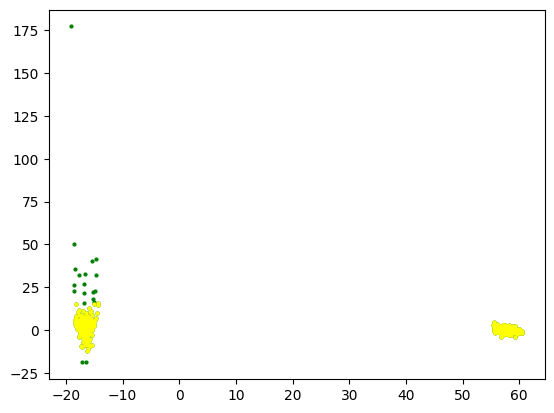

In [6]:
plt.scatter(X[:, 2], y, color = 'green', s = 4)
plt.scatter(X_no[:, 2], y_no, color = 'yellow', s = 4);

From this graph, we see that if we use the whole dataset to remove outliers, we have many more outliers in one of the clusters. Therefore, we decided to first split the data into the clusters and then remove outliers but only from cluster 1.

### Taking a look at the Data

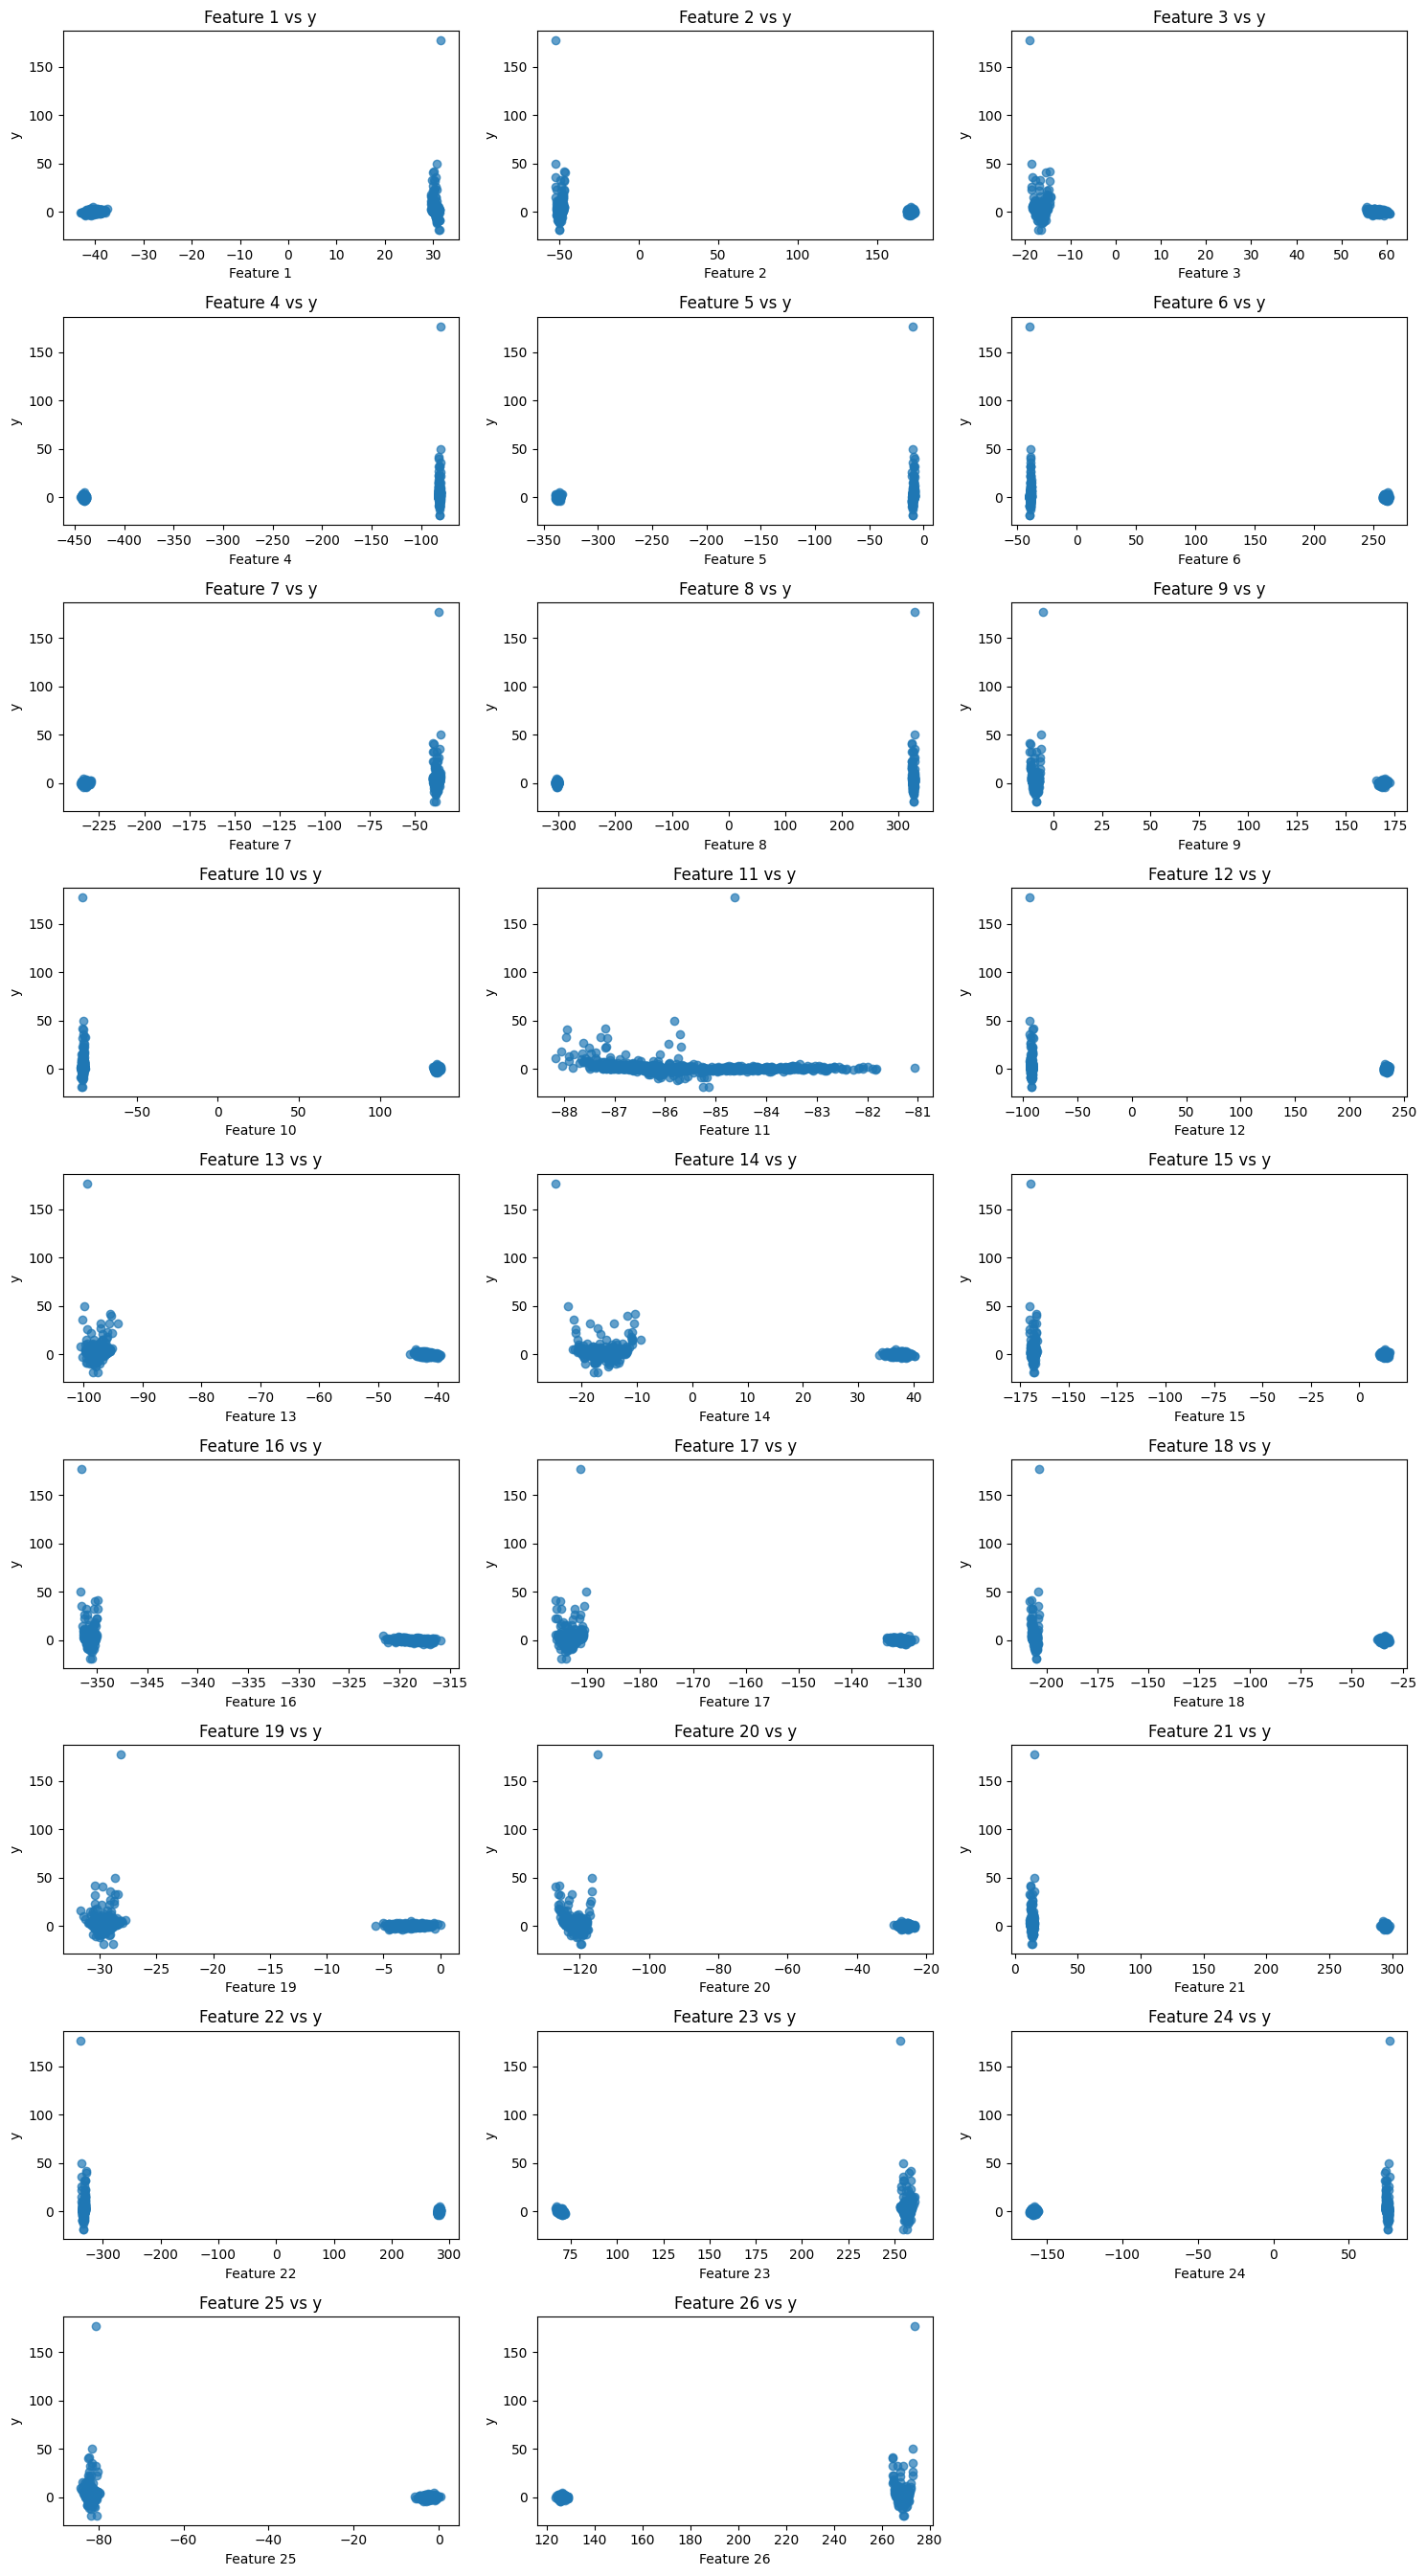

In [7]:
n_features = X.shape[1]
n_rows = np.ceil(n_features / 3).astype(int)  # Determine number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))  # 3 subplots per row
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Plot each feature against y
for i in range(n_features):
    axes[i].scatter(X[:, i], y, alpha=0.7)
    axes[i].set_title(f'Feature {i + 1} vs y')
    axes[i].set_xlabel(f'Feature {i + 1}')
    axes[i].set_ylabel('y')

# Remove any unused subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

From how the data is visualised, we can see that there are to different distributions of points in our dataset.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

### Correctly assigning points to each distribution

We do this by applying kmeans. Even though we can see from the training data that there is two distributions, we wanted to make the model more robust, because if the training data changes or is updated, then the model could start having issues.

Here we are simply testing that even with outliers, the model can correctly classify the points into the two clusters.

In [9]:
def assign_val_data_to_clusters_with_labels(X_test, y_test, cluster_means, cluster_labels):
    """
    Assigns test data and target values to clusters based on the minimum distance to the cluster means.
    The assigned clusters correspond to the labels of the closest training cluster.

    Parameters:
    X_test (array-like): Test data features.
    y_test (array-like): Test data target values.
    cluster_means (array-like): Means of the clusters obtained from training data.
    cluster_labels (array-like): Labels of the clusters.

    Returns:
    tuple: Test data and target values divided into clusters (X1_test, y1_test, X2_test, y2_test) based on 
    the corresponding cluster labels.
    """
    # Calculate the distance of each point in X_test to each cluster mean
    dist_to_means = np.linalg.norm(X_test[:, np.newaxis] - cluster_means, axis=2)
    # Determine the closest cluster mean for each test point
    closest_mean_indices = np.argmin(dist_to_means, axis=1)
    
    # Assign the test data to clusters based on the corresponding cluster labels
    X1_test = X_test[closest_mean_indices == cluster_labels[0]]
    y1_test = y_test[closest_mean_indices == cluster_labels[0]]
    X2_test = X_test[closest_mean_indices == cluster_labels[1]]
    y2_test = y_test[closest_mean_indices == cluster_labels[1]]
    
    return X1_test, y1_test, X2_test, y2_test

In [10]:
# Dividing the training data into two clusters given that it looks like the data comes from two different distributions

(X_train_clusters, y_train_clusters), clusters, labels = divide_data_by_kmeans_distance(
    x_train, y_train, n_clusters=2
)

X1_train, y1_train = X_train_clusters[0], y_train_clusters[0]
X2_train, y2_train = X_train_clusters[1], y_train_clusters[1]

# Calculate the mean of the second feature for each cluster
cluster_0_mean = clusters[0][1]
cluster_1_mean = clusters[1][1]

# This condition was only inseted to make sure that there was no issue in labels' assignment
# Ensure that cluster 1 has a mean of the second feature below 61 and cluster 2 above 61
if cluster_0_mean < 61 and cluster_1_mean > 61:
    print('No need to switch')
    # Cluster 0 is correct for averaging, Cluster 1 for Bayesian
    X1_train, y1_train = X_train_clusters[0], y_train_clusters[0]
    X2_train, y2_train = X_train_clusters[1], y_train_clusters[1]
elif cluster_1_mean < 61 and cluster_0_mean > 61:
    print('Had to switch')
    # Cluster 1 should be assigned to averaging, Cluster 0 to Bayesian
    X1_train, y1_train = X_train_clusters[1], y_train_clusters[1]
    X2_train, y2_train = X_train_clusters[0], y_train_clusters[0]
    labels = [1, 0]

# Using the means of the two clusters to determine which cluster each datapoint of the test data belongs to
X1_test, y1_test, X2_test, y2_test = assign_val_data_to_clusters_with_labels(x_test, y_test, clusters, labels)

No need to switch


### Checking if clusters have are balanced in terms of number of observations

In [11]:
print(f'Training length of Cluster 0: {len(X1_train)} \nTraining Length of Cluster 1: {len(X2_train)} \nTest length of Cluster 0: {len(X1_test)} \nTest length of Cluster1: {len(X2_test)}')

Training length of Cluster 0: 351 
Training Length of Cluster 1: 249 
Test length of Cluster 0: 122 
Test length of Cluster1: 78


### Visualising the train and test data clusters to make sure they were correctly classified

This is useful for testing purposes only.

We can change the number of the features X to show the comparison between different features

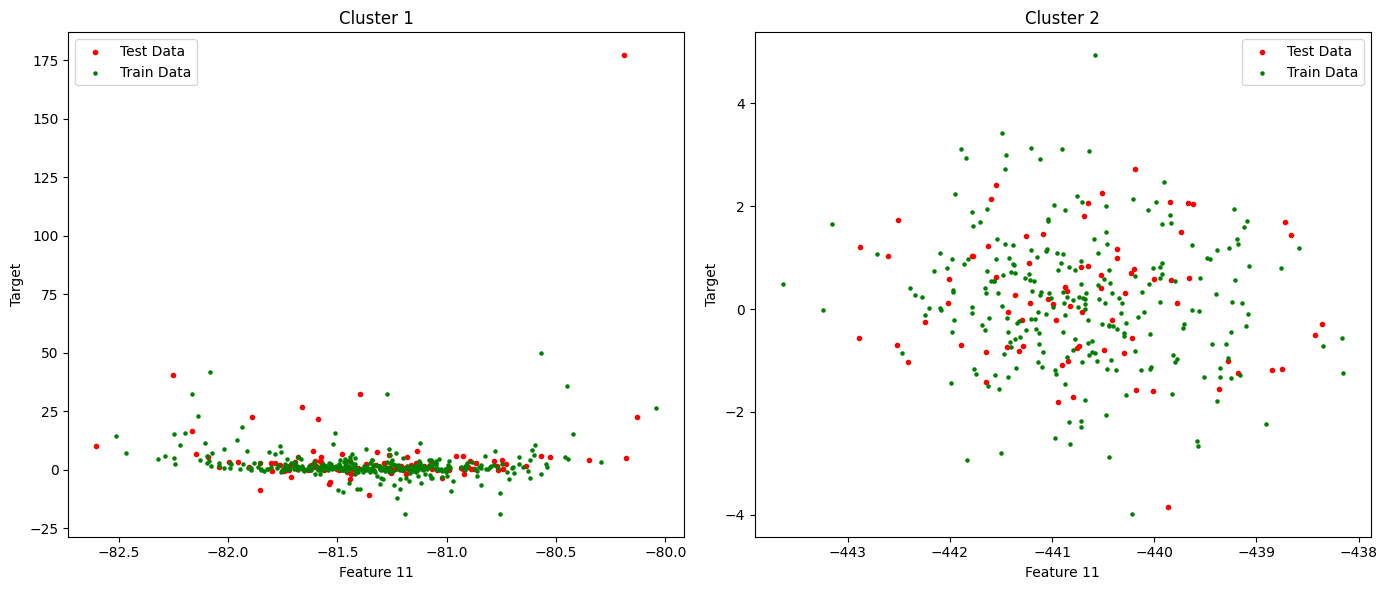

In [12]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# changing this value will change the X feature plotted
x_feature = 3

# First subplot for Cluster 1
axes[0].scatter(X1_test[:, x_feature], y1_test, color='red', label='Test Data', s = 9)
axes[0].scatter(X1_train[:, x_feature], y1_train, color='green', label='Train Data', s = 5)
axes[0].set_title('Cluster 1')
axes[0].set_xlabel('Feature 11')
axes[0].set_ylabel('Target')
axes[0].legend()

# Second subplot for Cluster 2
axes[1].scatter(X2_test[:, x_feature], y2_test, color='red', label='Test Data', s = 9)
axes[1].scatter(X2_train[:, x_feature], y2_train, color='green', label='Train Data', s = 5)
axes[1].set_title('Cluster 2')
axes[1].set_xlabel('Feature 11')
axes[1].set_ylabel('Target')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


This plot shows only one division of the train test split, however, for cluster 1 when we want to fine-tune our models, we want to consider different splits of the train-test data.

Additionally, from these graphs, we can see that:
- cluster 2 does not have many outliers
- cluster 1 has a bit of outliers

## Taking a look at the data based on the cluster labels

Here below we check if our assumption of having two distributions in the dataset could be correct by plotting the data colored using the cluster means. If there is a pefect separation between the two clusters, we will assume tha there are two distributions in the dataset.

This shows better plots when the data used doesn't have outliers (to do this, go to the outliers removal step and follow the steps, then rerun this cell).

In [13]:
def plot_clusters_features_vs_target(X_clusters, y_clusters, n_cols=3, figsize=(15, 10)):
    """
    Plots each feature in the clusters against the target variable, using different colors for each cluster.

    Parameters:
    X_clusters (list of array-like): List of feature matrices, one for each cluster.
    y_clusters (list of array-like): List of target vectors, one for each cluster.
    n_cols (int): Number of columns for the subplots.
    figsize (tuple): Size of the entire figure.
    """
    # Assuming all clusters have the same number of features
    n_features = X_clusters[0].shape[1]
    n_rows = (n_features + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle("Feature vs. Target (Colored by Cluster)", fontsize=16)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Plot each feature against the target variable for each cluster
    colors = ['blue', 'orange']  # Colors for the two clusters
    for i in range(n_features):
        ax = axes[i]
        for j, (X, y) in enumerate(zip(X_clusters, y_clusters)):
            ax.scatter(X[:, i], y, color=colors[j], alpha=0.6, label=f'Cluster {j+1}')
        ax.set_title(f"Feature {i+1} vs. Target (y)")
        ax.set_xlabel(f"Feature {i+1}")
        ax.set_ylabel("Target (y)")

    # Hide any unused subplots if there are any
    for j in range(n_features, len(axes)):
        axes[j].set_visible(False)

    # Add legend to the plot
    fig.legend(labels=[f'Cluster {i+1}' for i in range(len(X_clusters))], loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


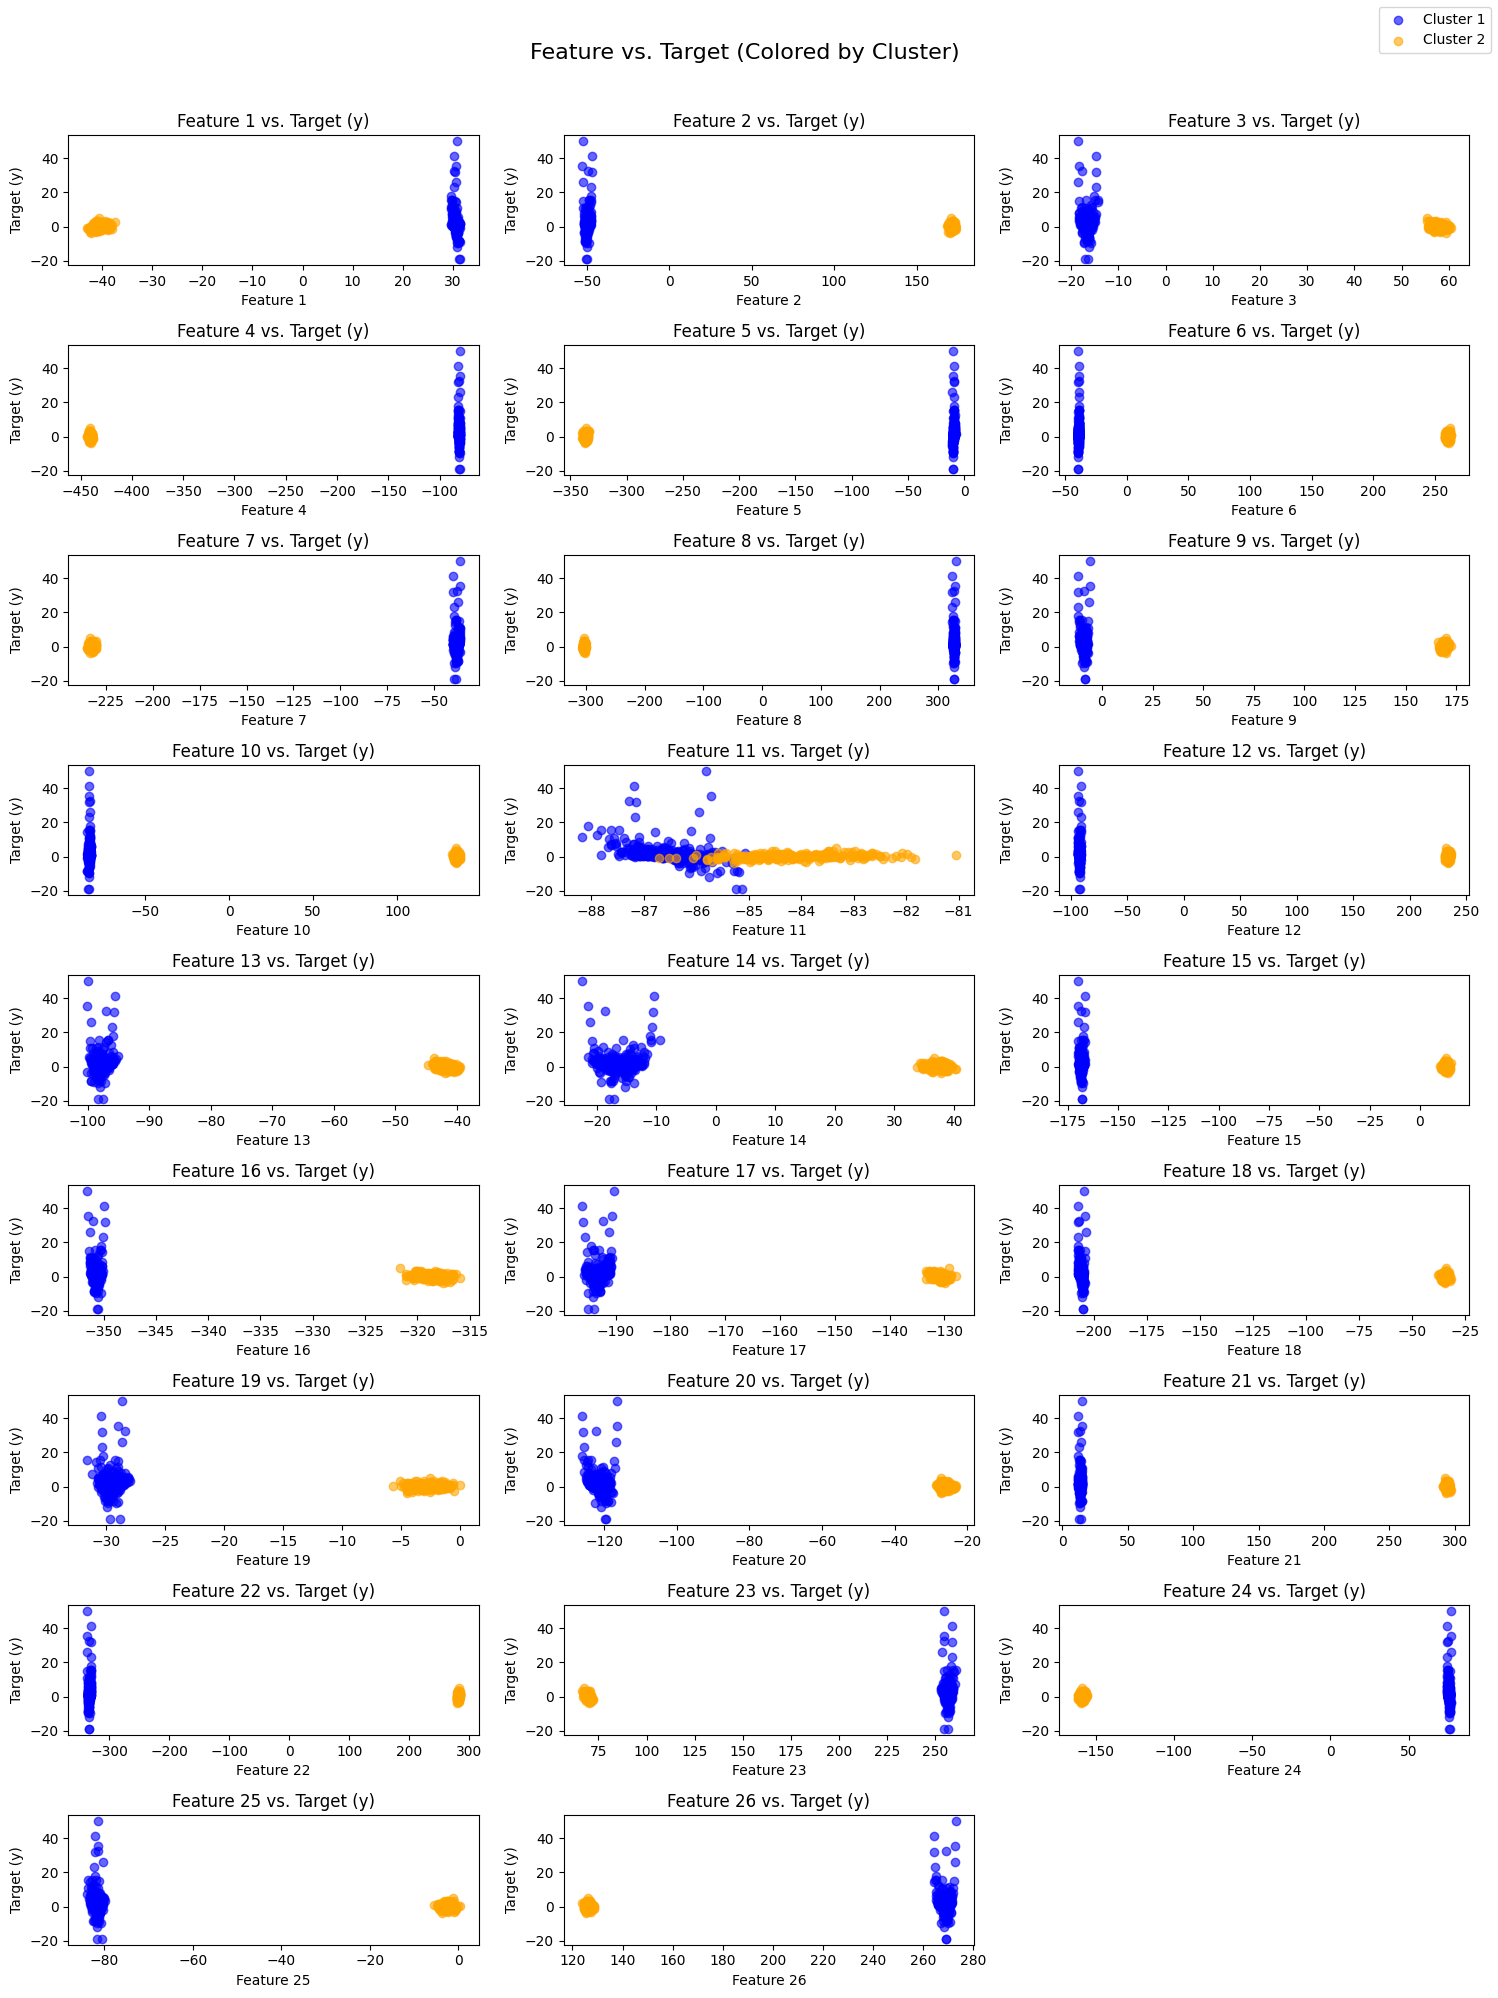

In [14]:
plot_clusters_features_vs_target(X_train_clusters, y_train_clusters, n_cols=3, figsize=(15, 20))

## Considering The Ball Shaped Cluster

Important: it is possible that the clustering algorithm changes the label of the cluster resulting in a switch between points in cluster 0 and 1. For this reason, please make sure that the clustering algorithm classifies correctly. Logic to do this has beeen implemented when doing the training split. However, the numbers used are based on our analysis and may change if x_train increases, since they are a simple estimate.

We assume Normal distribution of the data and apply the BayesianRidge model on the data which results in very accurate predictions.

Also, we saw that this training data does not have any outliers for the values of y, therefore we don't have to remove any.

In [15]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [16]:
# Create the polynomial features
# X2_train_poly, X2_test_poly = create_polynomial_features(X2_train, X2_test, degree = 5)

# Create the KNN Regressor model
model = BayesianRidge()

# Fit the model to the training data
model.fit(X2_train, y2_train)

y_pred_train = model.predict(X2_train)

# Make predictions on the test data
y_pred = model.predict(X2_test)

# Calculate the RMSE
rmse_value = rmse(y2_test, y_pred)

print(f'Training RMSE: {rmse(y2_train, y_pred_train)}')

print(f'Test RMSE: {rmse_value}')



Training RMSE: 7.755827949471562e-10
Test RMSE: 8.358844559732396e-10


Here, we didn't create a split to fine-tune this model because already on the default settings it was performing extremely well.

We can see that the Traning and Test RMSEs are close together and very small.

### Considering the Line Shaped Cluster

Here, we first need to remove the outliers from both the training and test data for cluster 2.

We tested both removing all the outliers above 1.5 and only the outlier with y > 150 and we decided to only remove the outlier of more than 150 from the data.

Then, we create multiple possibilities of X:
- standardised, using Standard Scaler
- pca
- poly, which was done both on original and scaled data (just replacing the x1_train(test)_scaled data with x1_train(test))

In [17]:
X1 = np.vstack((X1_train, X1_test))
y1 = np.concatenate((y1_train, y1_test))


print('Number of removed outliers:')
X1_no, y1_no = remove_outliers_y(X1, y1, 7)
#X1_no, y1_no = X1, y1

print('Percentage of removed outliers: ')
print((len(X1) - len(X1_no)) / len(X1))

Number of removed outliers:
16
Percentage of removed outliers: 
0.03382663847780127


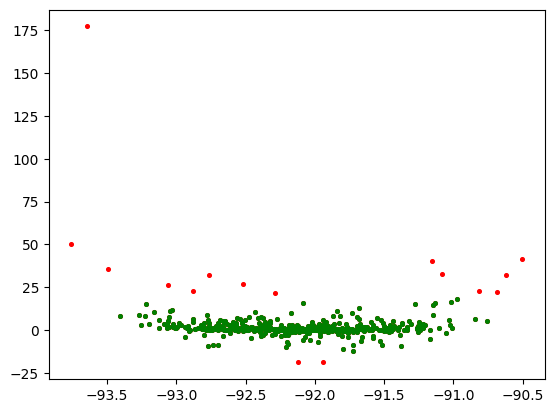

In [18]:
plt.scatter(X1[:, 11], y1, color = 'red', s = 7)
plt.scatter(X1_no[:, 11], y1_no, color = 'green', s = 7);

In [19]:
# splitting the data into training, validation and test sets
x1_train_no, x1_test_no, y1_train_no, y1_test_no = train_test_split(X1_no, y1_no)
x1_train_no, x1_val_no, y1_train_no, y1_val_no = train_test_split(x1_train_no, y1_train_no)

In [20]:
def standardize_data(X_train, X_test):

    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both the training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

def apply_pca(X_train, X_test, n_components=0.95):

    pca_transformer = PCA(n_components=n_components)

    # Fit the PCA transformer on the training data and transform both the training and testing data
    X_train_pca = pca_transformer.fit_transform(X_train)
    X_test_pca = pca_transformer.transform(X_test)

    return X_train_pca, X_test_pca

def create_polynomial_features(X_train, X_test, degree=2, include_bias=False):

    # Create a PolynomialFeatures object
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=include_bias)

    # Fit the transformer on the training data and transform both the training and testing data
    X_train_poly = poly_transformer.fit_transform(X_train)
    X_test_poly = poly_transformer.transform(X_test)

    return X_train_poly, X_test_poly

In [21]:
# applying various transformations to the data

x1_train_scaled, x1_val_scaled = standardize_data(x1_train_no, x1_val_no)
x1_train_pca, x1_val_pca = apply_pca(x1_train_no, x1_val_no, 0.95)
x1_train_poly_scaled, x1_val_poly_scaled = create_polynomial_features(x1_train_scaled, x1_val_scaled, 3)
x1_train_poly, x1_val_poly = create_polynomial_features(x1_train_no, x1_val_no, 3)
x1_train_poly_pca, x1_val_poly_pca = create_polynomial_features(x1_train_pca, x1_val_pca)

### Fine-tuning the models

This is done only on the training and validation sets to then be compared with the test set.

In [22]:
def tune_gaussian_process_regression(X_train, y_train, X_test, param_grid=None, cv=5):
    """
    Tunes the Gaussian Process regression model using GridSearchCV with a given parameter grid.
    Uses negative mean squared error as the scoring metric.

    Parameters:
    X_train (array-like): The training data features.
    y_train (array-like): The training target values.
    X_test (array-like): The testing data features.
    param_grid (dict): The parameter grid to search over. If None, a default grid will be used.
    cv (int): Number of cross-validation folds.

    Returns:
    best_model (GaussianProcessRegressor): The best Gaussian Process regression model found by GridSearchCV.
    best_params (dict): The best hyperparameters found by GridSearchCV.
    grid_search (GridSearchCV): The fitted GridSearchCV object.
    y_pred (array-like): Predictions made by the best model on the test set.
    """
    
    print(X_train.shape, X_test.shape)

    # Define a default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            'alpha': [1e-2, 1e-3, 1e-4],
            'kernel': [
                RBF(length_scale=10.0), 
                Matern(length_scale=10.0, nu=1.5), 
                RationalQuadratic(length_scale=10.0, alpha=0.1), 
                #ExpSineSquared(length_scale=1.0, periodicity=3.0)
            ]
        }

    # Create a Gaussian Process regression model
    gaussian_process = GaussianProcessRegressor()

    # Set up GridSearchCV with the Gaussian Process model and parameter grid
    grid_search = GridSearchCV(
        estimator=gaussian_process,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        #verbose=1,
    )

    # Fit the GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    return best_model, best_params, grid_search, y_pred

In [23]:
# checking best params based on grid search training and validation tests
best_model_gr, best_params_gr, grid_search_gr, y_pred_gr = tune_gaussian_process_regression(x1_train_pca, y1_train_no, x1_val_pca)
print(rmse(y1_val_no, y_pred_gr))

(256, 3) (86, 3)


/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/sit

3.104909136805335


In [24]:
x1_test_pca, _ = apply_pca(x1_test_no, x1_test_no, 0.95)
x1_test_pca = x1_test_pca[:, [0, 1, 2]]

y_pred_gr = best_model_gr.predict(x1_test_pca)

rmse(y1_test_no, y_pred_gr)

4.278462200187432

In [25]:
def tune_ridge_regression(X_train, y_train, X_test, param_grid=None, cv=15):

    # Define a default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            'alpha': [0, 0.1, 10.0, 100.0, 1000.0],
        }

    # Create a Ridge regression model
    ridge = Ridge()

    # Set up GridSearchCV with the Ridge model and parameter grid
    grid_search = GridSearchCV(
        estimator=ridge,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    # Fit the GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    return best_model, best_params, grid_search, y_pred

In [26]:
best_model_r, best_params_r, grid_search_r, y_pred_r = tune_ridge_regression(x1_train_pca, y1_train_no, x1_val_pca)
print(rmse(y1_val_no, y_pred_r))

Fitting 15 folds for each of 5 candidates, totalling 75 fits
3.388496463576724


In [27]:
y_pred_r = best_model_r.predict(x1_test_pca)

rmse(y1_test_no, y_pred_r)

4.631111435252409

In [28]:
def tune_kernel_ridge_regression(X_train, y_train, X_test, param_grid=None, cv=5):
    """
    Tunes the Kernel Ridge regression model using GridSearchCV with a given parameter grid.
    Uses negative mean squared error as the scoring metric.

    Parameters:
    X_train (array-like): The training data features.
    y_train (array-like): The training target values.
    X_test (array-like): The testing data features.
    param_grid (dict): The parameter grid to search over. If None, a default grid will be used.
    cv (int): Number of cross-validation folds.

    Returns:
    best_model (KernelRidge): The best Kernel Ridge regression model found by GridSearchCV.
    best_params (dict): The best hyperparameters found by GridSearchCV.
    grid_search (GridSearchCV): The fitted GridSearchCV object.
    y_pred (array-like): Predictions made by the best model on the test set.
    """

    print(X_train.shape, X_test.shape)

    # Define a default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            'alpha': [0.01, 0.1, 1.0, 10.0],
            'kernel': ['linear','rbf', 'poly', 'sigmoid'],
            'degree': [2, 3, 4]
        }

    # Create a Kernel Ridge regression model
    kernel_ridge = KernelRidge()

    # Set up GridSearchCV with the Kernel Ridge model and parameter grid
    grid_search = GridSearchCV(
        estimator=kernel_ridge,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    # Fit the GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    return best_model, best_params, grid_search, y_pred


In [29]:
best_model_kr, best_params_kr, grid_search_kr, y_pred_kr = tune_kernel_ridge_regression(x1_train_pca, y1_train_no, x1_val_pca)
print(rmse(y1_val_no, y_pred_kr))

(256, 3) (86, 3)
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution i

3.0836182557662073


/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution i

In [30]:
y_pred_kr = best_model_kr.predict(x1_test_pca)

rmse(y1_test_no, y_pred_r)

4.631111435252409

In [31]:
def tune_knn_regression(X_train, y_train, X_test, param_grid=None, cv=5):
    """
    Tunes the K-Nearest Neighbors regression model using GridSearchCV with a given parameter grid.
    Uses negative mean squared error as the scoring metric.

    Parameters:
    X_train (array-like): The training data features.
    y_train (array-like): The training target values.
    X_test (array-like): The testing data features.
    param_grid (dict): The parameter grid to search over. If None, a default grid will be used.
    cv (int): Number of cross-validation folds.

    Returns:
    best_model (KNeighborsRegressor): The best KNN regression model found by GridSearchCV.
    best_params (dict): The best hyperparameters found by GridSearchCV.
    grid_search (GridSearchCV): The fitted GridSearchCV object.
    y_pred (array-like): Predictions made by the best model on the test set.
    """

    print(X_train.shape, X_test.shape)

    # Define a default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            'n_neighbors': [3, 5, 7, 10],  # Number of neighbors to use
            'weights': ['uniform', 'distance'],  # Weight function used in prediction
            'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
        }

    # Create a KNeighborsRegressor model
    knn = KNeighborsRegressor()

    # Set up GridSearchCV with the KNN model and parameter grid
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        # verbose=1,  # Uncomment this line to get detailed output
    )

    # Fit the GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    return best_model, best_params, grid_search, y_pred

In [32]:
best_model_knn, best_params_knn, grid_search_knn, y_pred_knn = tune_knn_regression(x1_train_pca, y1_train_no, x1_val_pca)
print(rmse(y1_val_no, y_pred_knn))

(256, 3) (86, 3)
3.1490107313556384


In [33]:
y_pred_knn = best_model_knn.predict(x1_test_pca)

rmse(y1_test_no, y_pred_knn)

4.4549926419254655

In [34]:
print(f'Best Params Gaussian Regression: {best_params_gr}')
print(f'Best Params Ridge: {best_params_r}')
print(f'Best Params Kernel Regression: {best_model_kr}')
print(f'Best Params KNN Regression: {best_params_knn}')

Best Params Gaussian Regression: {'alpha': 0.01, 'kernel': RationalQuadratic(alpha=0.1, length_scale=10)}
Best Params Ridge: {'alpha': 100.0}
Best Params Kernel Regression: KernelRidge(alpha=10.0, degree=2, kernel='poly')
Best Params KNN Regression: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}


Now, we will use the following results to calculate an averaging model. Consider that the parameters might change slightly depending on the train test split.

In [35]:
# redefine the training and test data to use all data available

x1_train_no, x1_test_no, y1_train_no, y1_test_no = train_test_split(X1_no, y1_no)

x1_train_pca, x1_test_pca = apply_pca(x1_train_no, x1_test_no, 0.95)

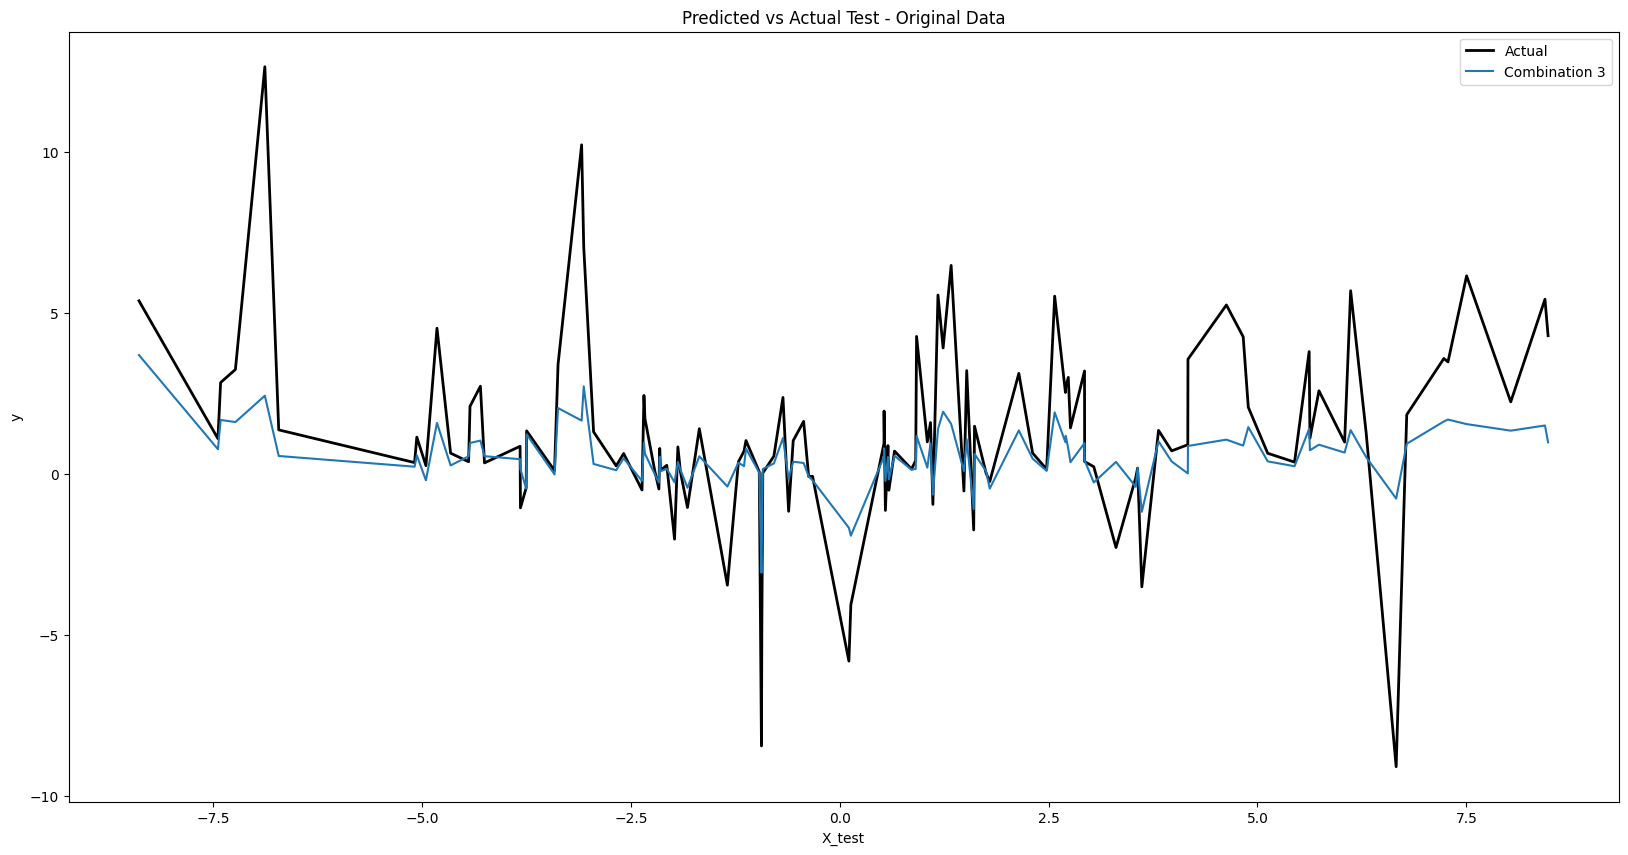

In [36]:
# Function to train, evaluate models, calculate weighted combination RMSE, and return predicted values
def evaluate_models_with_combinations(X1_train, X1_test, y1_train, y1_test, dataset_name):
    results = []
    predicted_y_values = {'train': {}, 'test': {}}

    model_knr = KNeighborsRegressor(n_neighbors=5, metric = 'manhattan', weights = 'distance')
    model_knr.fit(X1_train, y1_train)
    y_pred_train_knr = model_knr.predict(X1_train)
    y_pred_knr = model_knr.predict(X1_test)
    results.append([dataset_name, 'KNN Regressor', rmse(y1_train, y_pred_train_knr), rmse(y1_test, y_pred_knr)])
    predicted_y_values['train']['KNN Regressor'] = y_pred_train_knr
    predicted_y_values['test']['KNN Regressor'] = y_pred_knr

    # --- Gaussian Process Regressor ---
    model_gpr = GaussianProcessRegressor(alpha=0.01, kernel=RationalQuadratic(alpha=0.1, length_scale=10))
    model_gpr.fit(X1_train, y1_train)
    y_pred_train_g = model_gpr.predict(X1_train)
    y_pred_g = model_gpr.predict(X1_test)
    results.append([dataset_name, 'GaussianProcess Regressor', rmse(y1_train, y_pred_train_g), rmse(y1_test, y_pred_g)])
    predicted_y_values['train']['GaussianProcess Regressor'] = y_pred_train_g
    predicted_y_values['test']['GaussianProcess Regressor'] = y_pred_g

    # --- Ridge Regressor ---
    model_ridge = Ridge(alpha=100)
    model_ridge.fit(X1_train, y1_train)
    y_pred_train_r = model_ridge.predict(X1_train)
    y_pred_r = model_ridge.predict(X1_test)
    results.append([dataset_name, 'Ridge Regressor', rmse(y1_train, y_pred_train_r), rmse(y1_test, y_pred_r)])
    predicted_y_values['train']['Ridge Regressor'] = y_pred_train_r
    predicted_y_values['test']['Ridge Regressor'] = y_pred_r

    model_kr = KernelRidge(alpha=10, degree = 2, kernel = 'poly')
    model_kr.fit(X1_train, y1_train)
    y_pred_train_kr = model_ridge.predict(X1_train)
    y_pred_kr = model_ridge.predict(X1_test)
    results.append([dataset_name, 'Kernel Ridge', rmse(y1_train, y_pred_train_kr), rmse(y1_test, y_pred_kr)])
    predicted_y_values['train']['Kernel Ridge'] = y_pred_train_kr
    predicted_y_values['test']['Kernel Ridge'] = y_pred_kr

    # --- Check for NaNs in predictions ---
    if np.any(np.isnan([y_pred_r, y_pred_knr, y_pred_g, y_pred_kr])):
        print("NaN values found in predictions. Please check the models or data.")
        return results, predicted_y_values

    # --- Calculate inverse variances for weighted combination ---
    inv_var_r = 1 / np.var(y_pred_r) if np.var(y_pred_r) != 0 else 0
    inv_var_knr = 1 / np.var(y_pred_knr) if np.var(y_pred_knr) != 0 else 0
    inv_var_g = 1 / np.var(y_pred_g) if np.var(y_pred_g) != 0 else 0
    inv_var_kr = 1 / np.var(y_pred_kr) if np.var(y_pred_kr) != 0 else 0

    # Calculate weights (avoid division by zero)
    total_inv_var = inv_var_r + inv_var_knr + inv_var_g + inv_var_kr
    if total_inv_var == 0:
        return results, predicted_y_values  # No valid combination if all variances are zero

    w_r = inv_var_r / total_inv_var if inv_var_r != 0 else 0
    w_knr = inv_var_knr / total_inv_var if inv_var_knr != 0 else 0
    w_g = inv_var_g / total_inv_var if inv_var_g != 0 else 0
    w_kr = inv_var_kr / total_inv_var if inv_var_kr!= 0 else 0

    # List of combinations for the weights (ensuring they sum to 1)
    combinations = [
        (w_r, w_knr, 0, 0),          # y_pred_r and y_pred_knr, ignore y_pred_g and y_pred_kr
        (w_r, 0, w_g, 0),            # y_pred_r and y_pred_g, ignore y_pred_knr and y_pred_kr
        (0, w_knr, w_g, 0),          # y_pred_knr and y_pred_g, ignore y_pred_r and y_pred_kr
        (w_r, w_knr, w_g, 0),        # y_pred_r, y_pred_knr, and y_pred_g, ignore y_pred_kr
        (w_r, 0, 0, w_kr),           # y_pred_r and y_pred_kr, ignore y_pred_knr and y_pred_g
        (0, w_knr, 0, w_kr),         # y_pred_knr and y_pred_kr, ignore y_pred_r and y_pred_g
        (0, 0, w_g, w_kr),           # y_pred_g and y_pred_kr, ignore y_pred_r and y_pred_knr
        (w_r, w_knr, 0, w_kr),       # y_pred_r, y_pred_knr, and y_pred_kr, ignore y_pred_g
        (w_r, 0, w_g, w_kr),         # y_pred_r, y_pred_g, and y_pred_kr, ignore y_pred_knr
        (0, w_knr, w_g, w_kr),       # y_pred_knr, y_pred_g, and y_pred_kr, ignore y_pred_r
        (w_r, w_knr, w_g, w_kr)      # All predictions: y_pred_r, y_pred_knr, y_pred_g, and y_pred_kr
    ]

    # Calculate RMSE for each combination (both Train and Test)
    for i, (wr, wknr, wg, wkr) in enumerate(combinations):
        # Train RMSE for combination
        y_pred_train_combined = (
            y_pred_train_r * wr + 
            y_pred_train_knr * wknr + 
            y_pred_train_g * wg + 
            y_pred_train_kr * wkr
        )
        train_rmse = rmse(y1_train, y_pred_train_combined)

        # Test RMSE for combination
        y_pred_combined = (
            y_pred_r * wr + 
            y_pred_knr * wknr + 
            y_pred_g * wg + 
            y_pred_kr * wkr
        )
        test_rmse = rmse(y1_test, y_pred_combined)

        # Append results
        results.append([dataset_name, f'Combination {i+1} (w_r={wr:.3f}, w_knr={wknr:.3f}, w_g={wg:.3f}, w_kr={wkr:.3f})', train_rmse, test_rmse])
        predicted_y_values['train'][f'Combination {i+1}'] = y_pred_train_combined
        predicted_y_values['test'][f'Combination {i+1}'] = y_pred_combined

    return results, predicted_y_values


# Collecting results for all datasets
results = []
all_predicted_y = {'train': {}, 'test': {}}
datasets = [
    ('PCA Data', x1_train_pca, x1_test_pca),
    ('Original Data', x1_train_no, x1_test_no)
]

for dataset_name, X1_train, X1_test in datasets:
    res, pred_y = evaluate_models_with_combinations(X1_train, X1_test, y1_train_no, y1_test_no, dataset_name)
    results.extend(res)
    all_predicted_y['train'].update(pred_y['train'])
    all_predicted_y['test'].update(pred_y['test'])

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Dataset', 'Model/Combination', 'Train RMSE', 'Test RMSE'])

# Save results
results_df.to_csv('FinalResults.csv')

# Plotting function for predicted vs actual
def plot_predictions(X_test, y_test, y_pred_dict, dataset_name):
    plt.figure(figsize=(20, 10))
    
    # Sort X_test and y_test for consistent plotting
    sorted_idx = np.argsort(X_test[:, 0])
    X_test_sorted = X_test[sorted_idx]
    y_test_sorted = y_test[sorted_idx]
    
    plt.plot(X_test_sorted[:, 0], y_test_sorted, label='Actual', color='black', linewidth=2)
    
    # Plot predictions from each model
    for model_name, y_pred in y_pred_dict.items():
        if model_name == 'Combination 3':
            y_pred_sorted = y_pred[sorted_idx]
            plt.plot(X_test_sorted[:, 0], y_pred_sorted, label=model_name)

    plt.title(f'Predicted vs Actual Test - {dataset_name}')
    plt.xlabel('X_test')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Example: Plot predictions for the 'Original Data'
plot_predictions(x1_test_pca, y1_test_no, all_predicted_y['test'], 'Original Data')

You can use line 137 to decide which points you want to show

At the end we decide to use GaussianRegressionProcesses and KNRegressor to obtain y_predictions that then are averaged based on their inverse variances to get the final y prediction.

Since using weights = 'distance' in KNRegressor would overfit the data, we decide to use the 'uniform' option for this parameter.

This applies to cluster 1